In [6]:
#import basic libraries
import pandas as pd
import json
import numpy as np

#import data manipulation libraries
import datetime
import tldextract

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#Natural Language Processing libraries
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer

#Clustering KNN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [7]:
with open("BrowserHistory.json", encoding="utf8") as f:
    data = json.loads(f.read())
    browser_history = pd.DataFrame(data["Browser History"])

In [8]:
browser_history.drop(['client_id','favicon_url'], axis=1, inplace=True)
browser_history.head(3)

,page_transition,title,url,time_usec
0,LINK,Google Takeout,https://takeout.google.com/,1667376759925466
1,LINK,Google Takeout,https://takeout.google.com/,1667376754338299
2,LINK,Google Takeout,https://takeout.google.com/,1667376740198031


In [9]:
browser_history['page_transition'].unique()

array(['LINK', 'FORM_SUBMIT', 'TYPED', 'GENERATED', 'AUTO_BOOKMARK',
       'RELOAD', 'AUTO_TOPLEVEL'], dtype=object)

In [10]:
browser_history = browser_history.loc[(browser_history['page_transition'] == 'LINK') | (browser_history['page_transition'] == 'TYPED')].reset_index(drop=True) 
browser_history['page_transition'].unique()

array(['LINK', 'TYPED'], dtype=object)

In [11]:
browser_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39831 entries, 0 to 39830
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   page_transition  39831 non-null  object
 1   title            39831 non-null  object
 2   url              39831 non-null  object
 3   time_usec        39831 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [12]:
def convert_time(x):
    return datetime.datetime.fromtimestamp(x/1000000)
browser_history['date_time'] = browser_history['time_usec'].apply(convert_time)
browser_history.drop('time_usec', inplace = True, axis= 1)

In [13]:
browser_history['date'] = browser_history['date_time'].dt.date

In [14]:
def convert_year(x):
    return int(x.year)
browser_history['year'] = browser_history['date_time'].apply(convert_year)

In [15]:
month_in_year = {1 : 'January',
               2 : 'February',
               3 : 'March',
               4 : 'April',
               5 : 'May',
               6 : 'June',
               7 : 'July',
               8 : 'August',
               9 : 'September',
               10 : 'October',
               11 : 'November',
               12 : 'December'}
def conver_month(x):
    return int(x.month)
browser_history['month'] = browser_history['date_time'].apply(conver_month)
browser_history['month'].replace(month_in_year, inplace= True)

In [16]:
def convert_hour(x):
    return int(x.hour)
browser_history['hour'] =  browser_history['date_time'].apply(convert_hour)

In [17]:
day_in_week = {0 : 'Monday',
               1 : 'Tuesday',
               2 : 'Wednesday',
               3 : 'Thursday',
               4 : 'Friday',
               5 : 'Saturday',
               6 : 'Sunday'}

def convert_day(x):
    return (x.weekday())
browser_history['day'] = browser_history['date_time'].apply(convert_day)
browser_history['day'].replace(day_in_week, inplace= True)


In [18]:
weekday = []
for x in browser_history['date_time']:
    if x.weekday() <= 4:
        weekday.append('Yes')
    else:
        weekday.append('No')
browser_history['weekday'] = weekday

In [19]:
safe_website = []
for x in browser_history['url']:
    if x.startswith('https'):
        safe_website.append('Yes')
    else:
        safe_website.append('No')
browser_history['safe_website'] = safe_website

In [20]:
domain = []
for x in browser_history['url']:
    domain_name = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if domain_name == 'google':
        domain.append('{}_{}'.format(domain_name, sub_domain))
    else:
        domain.append(domain_name)
browser_history['domain'] = domain

In [21]:
search_category = []
for x in browser_history['domain']:
    if x in ['telegram', 'youtube', 'linkedin', 'tiktok', 'facebook','whatsapp']:
        search_category.append('Social_media')
    elif x in ['google_www','newtab']:
        search_category.append('Seaching')
    elif x in ['gmail', 'google_mail']:
        search_category.append('email')
    elif x in ['datacamp', 'rakamin', 'github', 'ipusnas','datagy', 'kaggle', 'medium', 'matplotlib', 'numpy','brainly', 'zenius','google_classroom','google_classroom']:
        search_category.append('Learning')
    elif x in ['blibli', 'bukalapak', 'shopee', 'olx']:
        search_category.append('Shopping')
    elif x in ['linkedin', 'glints','jobstreet']:
        search_category.append('Jobs_searching')
    elif x in ['kompas', 'cnnindonesia']:
        search_category.append('News')
    elif x in ['google_scholar','coursehero','sciencedirect','google_docs']:
        search_category.append('Scholarly_literature')
    elif x in ['zoom','google_meet']:
        search_category.append('Online_meeting')
    else:
        search_category.append('other')
browser_history['search_category'] = search_category

In [22]:
browser_history.head(3)

,page_transition,title,url,date_time,date,year,month,hour,day,weekday,safe_website,domain,search_category
0,LINK,Google Takeout,https://takeout.google.com/,2022-11-02 15:12:39.925466,2022-11-02,2022,November,15,Wednesday,Yes,Yes,google_takeout,other
1,LINK,Google Takeout,https://takeout.google.com/,2022-11-02 15:12:34.338299,2022-11-02,2022,November,15,Wednesday,Yes,Yes,google_takeout,other
2,LINK,Google Takeout,https://takeout.google.com/,2022-11-02 15:12:20.198031,2022-11-02,2022,November,15,Wednesday,Yes,Yes,google_takeout,other


Exploratory data analysis

In [23]:
#Secure Website VS Unsecure Website that user browse
df_secure_unsecure = browser_history['safe_website'].value_counts()

fig = px.pie(df_secure_unsecure, names=df_secure_unsecure.index, values =df_secure_unsecure.values,
             color=df_secure_unsecure.index, template='seaborn',
             title='<b> Secure Website VS Unsecure Website That User Browse?',width=600, height=400)

fig.show()


In [24]:
#What day is the most used on browsing
df_day_count = browser_history['day'].value_counts()

fig = px.bar(df_day_count, x=df_day_count.index,y=df_day_count.values,
        color=df_day_count.index, labels= {'index':'Day in Weeks', 'y' : 'Count'},
        template='seaborn',title='<b> What Day is The Most Used on Browsing?',width=750, height=600, 
        text_auto='.2s')

fig.update_traces(textposition='outside', cliponaxis=False)
fig.update_layout(xaxis={'categoryarray':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

fig.show( )

In [25]:
#what month is the most used on browsing?
df_month_count = browser_history['month'].value_counts(sort=False)

fig = px.bar(df_month_count, x=df_month_count.index,y=df_month_count.values,
        color=df_month_count.index, labels= {'index':'Month', 'y' : 'Count'},
        template='seaborn',title='<b> What Month is The Most Used on Browsing?',width=750, height=600, 
        text_auto='.2s')

fig.update_traces(textposition='outside')
fig.update_layout(xaxis={'categoryarray':['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']})


fig.show()

In [26]:
#What is The most Category That User Browse
df_top_category = browser_history['search_category'].value_counts()

fig = px.pie(df_top_category, names=df_top_category.index, values =df_top_category.values,
        color=df_top_category.index, template='seaborn',title='<b> What is The most Category That User Browse?',
        width=600, height=500)

fig.show()

In [27]:
#What is the most learning domain use by user
df_top_learn = browser_history[browser_history['search_category'] == 'Learning']
df_top_learn = df_top_learn['domain'].value_counts()

fig = px.pie(df_top_learn, names=df_top_learn.index, values =df_top_learn.values,
        color=df_top_learn.index, template='seaborn',title='<b> What is The Most Learning Website Use by User?',width=600, height=500)

fig.show()

In [28]:
#When is User Browsing To Learning
heatmap = browser_history[browser_history['search_category'] == 'Learning']
heatmap = heatmap.groupby(['hour', 'day'], as_index= False)['search_category'].count()
heatmap = heatmap.pivot('hour','day', 'search_category')

fig = px.imshow(heatmap, text_auto= '', color_continuous_scale= 'greens'
                ,width=750, height=600, title='<b> When is User Browsing To Learning')

fig.update_layout(xaxis={'categoryarray':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

fig.show()

In [29]:
#How often user use google chrome for learning purposes in a week?
df_learning = browser_history[browser_history['search_category'] == 'Learning']
df_learning = df_learning.groupby(['day'], as_index= False)['search_category'].count()

fig = px.bar(df_learning, x= 'day', y = 'search_category', color = 'day', labels= {'day':'Day', 'search_category' : 'Learning Count'},
             template='seaborn',title='<b> How often user use google chrome for learning purposes in a week?',
             width=700, height=600,  text_auto='.2s')

fig.update_traces(textposition='outside')
fig.update_layout(xaxis={'categoryarray':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

fig.show()

In [30]:
#When Does The User Use Googleclassroom in 24 Hour?
df_googleclassroom = browser_history[browser_history['domain'] == 'google_classroom']
df_googleclassroom = df_googleclassroom.groupby(['hour'])['domain'].count()

fig = px.bar(df_googleclassroom, x=df_googleclassroom.index,y=df_googleclassroom.values,
             color=df_googleclassroom.index, labels= {'day':'Day in Weeks', 'y' : 'Google Classroom Visited'},
             template='seaborn',title='<b> When Does The User Use Googleclassroom in 24 Hour?'
             ,width=750, height=600, text_auto='')

fig.update_traces(textposition='outside')
fig.update_layout(xaxis={'categoryarray':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

fig.show()


In [31]:
#What is The most Domain That User Browse
df_top_domain = browser_history['domain'].value_counts().head(10)

fig = px.bar(df_top_domain, x=df_top_domain.index,y=df_top_domain.values,
        color=df_top_domain.index, labels= {'index':'Domain', 'y' : 'Count'},
        template='seaborn',title='<b> What is The most Domain That User Browse?',width=750, height=600, 
        text_auto='.2s', color_discrete_sequence = px.colors.qualitative.Set3)

fig.update_traces(textposition='outside')

fig.show()

In [32]:
#How often user use youtube domain in the entire month?
df_youtube = browser_history[browser_history['domain'] == 'youtube']
df_youtube = df_youtube.groupby(['month','weekday'],as_index= False)['domain'].count()

fig = px.bar(df_youtube, x= 'month',y= 'domain',labels= {'domain':'youtube count', 'weekday' : 'Is it weekday?'},
        color='weekday', template='seaborn',title='<b> How Often User Use Youtube Domain in The Entire Month?',
        width=750, height=600, text_auto='.2s')


fig.show()

In [33]:
#lets check the most search domain
browser_history[browser_history['domain'] == 'datacamp'].groupby(['title','url'],as_index = False)['domain'].count().sort_values(by = 'domain').tail(10)

,title,url,domain
587,Writing an iterator to load data in chunks (3)...,https://campus.datacamp.com/courses/python-dat...,10
5,A little bit of Twitter text analysis | Python,https://campus.datacamp.com/courses/intermedia...,11
305,Joining Data with pandas - Statement of Accomp...,https://www.datacamp.com/statement-of-accompli...,12
177,DataCamp Learn,https://app.datacamp.com/learn/#,16
464,Skill Tracks - DataCamp Learn,https://app.datacamp.com/learn/skill-tracks,21
139,Data Scientist with Python Track - DataCamp Learn,https://app.datacamp.com/learn/career-tracks/d...,23
61,Career Tracks - DataCamp Learn,https://app.datacamp.com/learn/career-tracks,29
176,DataCamp Learn,https://app.datacamp.com/learn/,41
317,"Learn R, Python & Data Science Online | DataCamp",https://www.datacamp.com/,66
175,DataCamp Learn,https://app.datacamp.com/learn,91


WORD CLOUD

In [34]:
#Lets analze deep down to youtube domain
df_title_youtube = browser_history[browser_history['domain'] == 'youtube']
df_title_youtube = df_title_youtube.groupby(['title','url'], as_index = False)['domain'].count().sort_values(by = 'domain', ascending = False)
df_title_youtube.head()
#Since there is no information youtube.com, we gonna drop it
df_title_youtube.drop(df_title_youtube[df_title_youtube['url'] == 'https://www.youtube.com/'].index	, inplace= True)
df_title_youtube.drop(df_title_youtube[df_title_youtube['title'] == '(16) YouTube'].index, inplace= True)
df_title_youtube.drop(df_title_youtube[df_title_youtube['title'] == '(5) YouTube'].index, inplace= True)
df_title_youtube.drop(df_title_youtube[df_title_youtube['title'] == '(3) YouTube'].index, inplace= True)
df_title_youtube.drop(df_title_youtube[df_title_youtube['title'] == 'YouTube'].index	, inplace= True)
#we gonna drop the url column because we didnt need it
df_title_youtube.drop(labels= 'url', axis=1, inplace= True)
df_title_youtube.reset_index(drop= True,inplace =True)

df_title_youtube.head(20)

,title,domain
0,Runtuh - Feby Putri Feat. Fiersa Besari (Live ...,11
1,lofi hip hop radio - beats to relax/study to -...,11
2,"No lie, Feel your eyes, they all over me | Sea...",10
3,feby putri - YouTube,8
4,tasm opening scene - YouTube,8
5,income 2021 - YouTube,7
6,(66) ms word subscription expired - YouTube,7
7,Somebody That I Used To Know - Gotye (Lyrics) ...,7
8,Chase Atlantic - Swim / Lyrics - YouTube,7
9,"Blackway & Black Caviar - ""What's Up Danger"" (...",6


(-0.5, 1023.5, 591.5, -0.5)

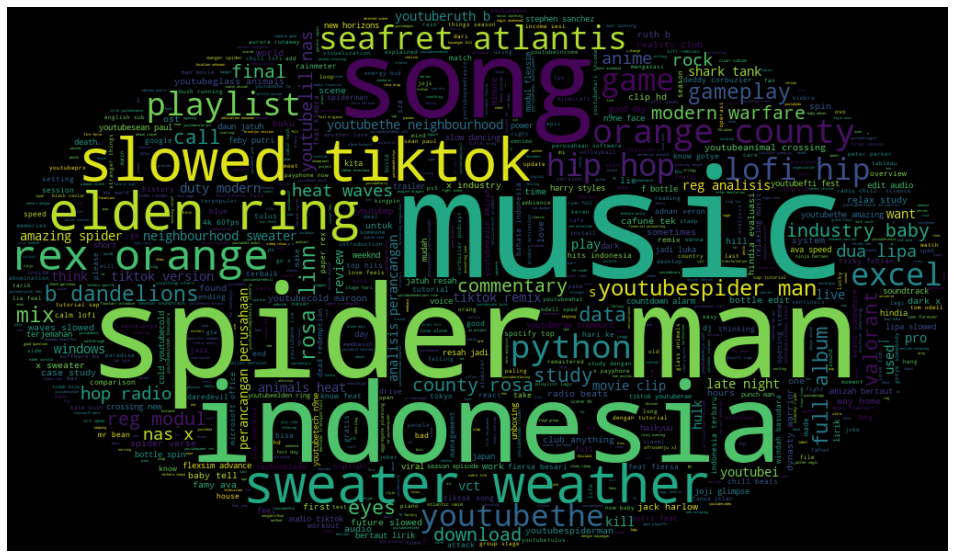

In [35]:
#Lets see word cloud from youtube title that user visit
df_top_youtube = ''.join(df_title_youtube['title']).lower()

image = np.array(Image.open('phploeBuh.png'))

sw = set(STOPWORDS)
more_sw = set(['youtube', 'v', 'di', 'dan', 'ft', 'VS', 'lyric','lyrics','best', 'ini','video','u',
               'youtubehow','official','yang','part','cara','hour','us'])
sw |= more_sw

wc = WordCloud(background_color="black", max_words=1000, mask=image,
               stopwords=sw, contour_width=3, contour_color='black')

wc.generate(df_top_youtube)

plt.figure(figsize=(35,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

TF-IDF

In [36]:
#Lets Cleaning the list of text

#Make new list from dataframe
list_title_youtube = df_title_youtube['title'].values.tolist()
list_title_youtube = [word.lower() for word in list_title_youtube]
#Make a list of stopword
sw_indonesia = StopWordRemoverFactory()
sw_englsih = stopwords.words('english')
sw_data = sw_indonesia.get_stop_words() + sw_englsih
#Make Function that accept a string as a parameter and will return the sentence
def remove_stop(teks, sw):
    words = teks.split()
    clean = []
    for word in words:
        if word not in sw:
            clean.append(word)
    clean = ' '.join(clean)
    clean = clean.translate(str.maketrans('', '', string.punctuation))
    clean = ''.join([i for i in clean if not i.isdigit()])
    while '  ' in clean:
        clean = clean.replace('  ', ' ')
    return clean

def cleaning_list(list):
    clean = []
    for string in list:
        clean_string = remove_stop(string, sw_data)
        clean.append(clean_string)
    return clean

#Make new list that already clean
list_youtube_clean = cleaning_list(list_title_youtube)
print(list_title_youtube[999])
print(list_youtube_clean[999])

quantum physics for babies reviewed by a physicist | what the physics? - youtube
quantum physics babies reviewed physicist physics youtube


In [37]:
#TF-IDF Weights on clean list of data
vectorizer = TfidfVectorizer(stop_words= 'english',
                             lowercase= True,
                             max_df = 0.8,
                             min_df = 5)
vector = vectorizer.fit_transform(list_youtube_clean)
#Build Clustering Using K-Means
k = 4
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(vector)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
#Now we can see each cluster
print("Top terms per cluster:")
for x in range(k):
    print("Cluster %a:" %x)
    for ind in order_centroids[x, :3]:
        print(' %s' % terms[ind])
    print
#We can also make prediction of a text
title ='amazing spiderman jumps'
Y = vectorizer.transform([title])
prediction = model.predict(Y)
("Your Search of '{}' is in the {} cluster".format(title , prediction.item()))

Top terms per cluster:
Cluster 0:
 tank
 shark
 kevin
Cluster 1:
 way
 home
 spiderman
Cluster 2:
 lyrics
 indonesia
 vs
Cluster 3:
 video
 official
 lyric


c:\Users\rafly\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



"Your Search of 'amazing spiderman jumps' is in the 2 cluster"

KNN Visualization

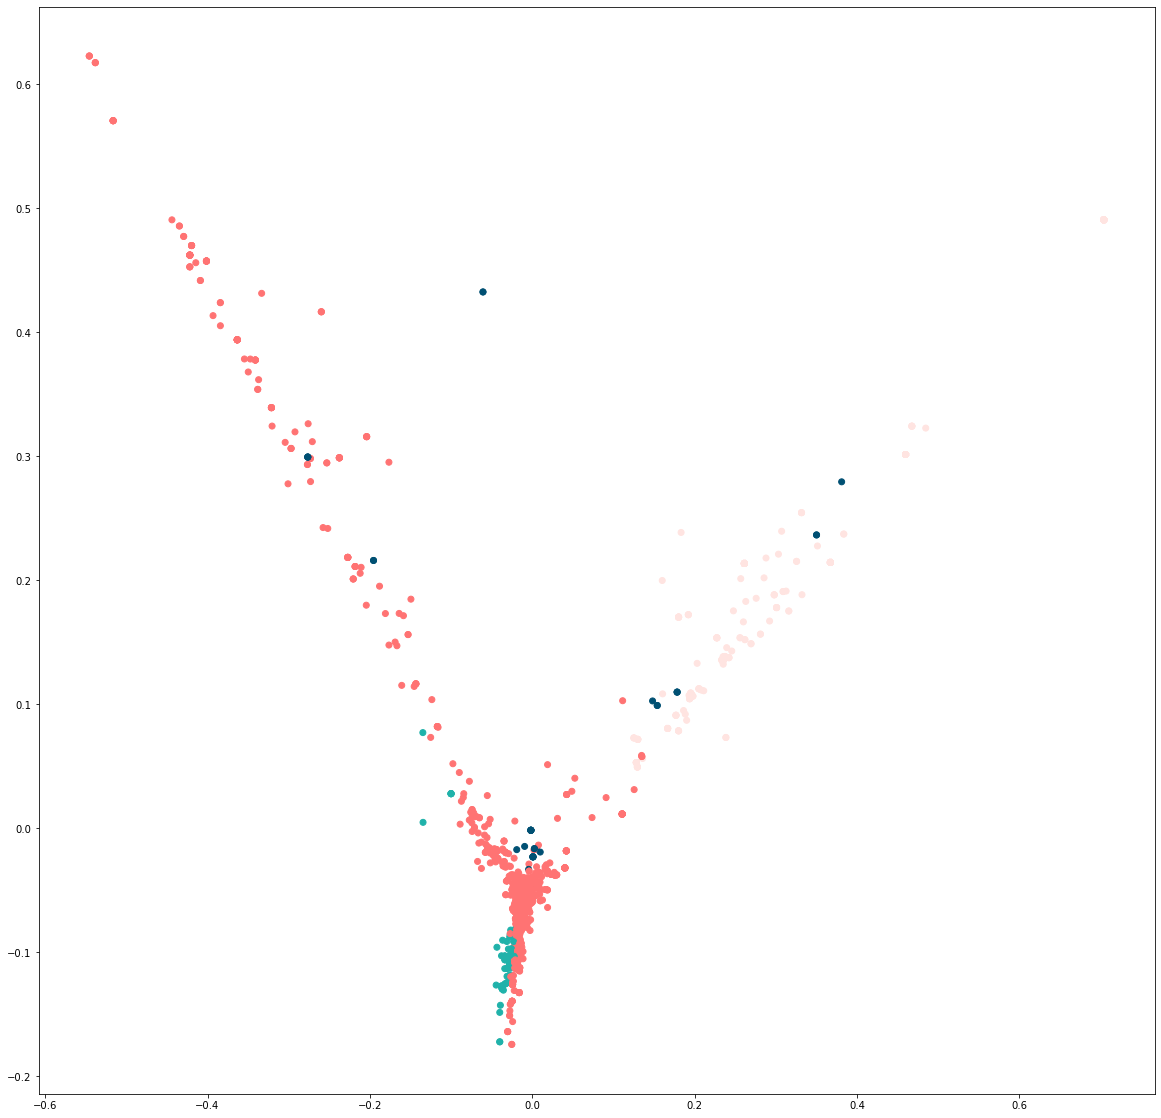

In [38]:
#Vizualize KNN-Cluster
Kmeans_indices = model.fit_predict(vector)

pca = PCA(n_components= 2)
scatter_plot_points = pca.fit_transform(vector.toarray())

labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
x_axis = [i[0] for i in scatter_plot_points]
y_axis = [i[1] for i in scatter_plot_points]

fig, ax = plt.subplots(figsize = (20,20))

ax.scatter(x_axis,y_axis, c = [labels_color_map[d] for d in Kmeans_indices])
plt.show()